In [1]:
# basic python data handling analysis modules
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
# small utility functions
from utility import *

# interactive jupyter widgets!
# https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

%matplotlib inline

In [2]:
Dataset_directory = ".."+os.sep+"Datasets"+os.sep

In [3]:
## (1) PERSONALITY DATASET: PERS
## (2) SERENDIPTY DATASET: SER
## (3) LEARNING DATASET: LEARN
## (4) HETREC DATASET: HETREC
## (5) ML LATEST DATASET: ML

## (6) the-numbers.com DATASET: NUM

## (7) themoviedb.org DATASET: TMB (yes it's missing a D, but I'm not changing my scripts now!)


In [4]:
## (1) PERSONALITY DATASET

# Dataset Citation: Nguyen, T.T., Maxwell Harper, F., Terveen, L. et al. Inf Syst Front (2018) 20: 1173.
# https://doi.org/10.1007/s10796-017-9782-y

# The personality-data.csv file contains the data about the personalities and the
# movie preferences of 1834 users.
# The ratings.csv file contains the ratings of users in the personality-data.csv
# file contributed.
personality_dataset = "personality-isf2018"

# userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion,assigned metric,
# assigned condition,movie_1,predicted_rating_1,movie_2,predicted_rating_2,movie_3,predicted_rating_3,movie_4,
# predicted_rating_4,movie_5,predicted_rating_5,movie_6,predicted_rating_6,movie_7,predicted_rating_7,movie_8,
# predicted_rating_8,movie_9,predicted_rating_9,movie_10,predicted_rating_10,movie_11,predicted_rating_11,
# movie_12,predicted_rating_12,is_personalized,enjoy_watching (1834, 34)
PERS_personality_data = pd.read_csv(Dataset_directory+ personality_dataset +os.sep+"personality-data.csv")
# Userid: the hashed user_id.
# Openness: an assessment score (from 1 to 7) assessing user tendency to prefer new experience. 1 means the user has tendency NOT to prefer new experience, 7 means the user has tendency to prefer new experience.
# Agreeableness: an assessment score (from 1 to 7) assessing user tendency to be compassionate and cooperative rather than suspicious and antagonistic towards others. 1 means the user has tendency to NOT be compassionate and cooperative. 7 means the user has tendency to be compassionate and cooperative.
# Emotional Stability: an assessment score (from 1 to 7) assessing user tendency to have psychological stress. 1 means the user has tendency to have psychological stress, and 7 means the user has tendency to NOT have psychological stress.
# Conscientiousness: an assessment score (from 1 to 7) assessing user tendency to be organized and dependable, and show self-discipline. 1 means the user does not have such a tendency, and 7 means the user has such tendency.
# Extraversion: an assessment score (from 1 to 7) assessing user tendency to be outgoing. 1 means the user does not have such a tendency, and 7 means the user has such a tendency.

# Assigned Metric: one of the follows (serendipity, popularity, diversity, default). Each user, besides being assessed their personality, was evaluated their preferences for a list of 12 movies manipulated with serendipity, popularity, diversity value or none (default option).
# Assigned Condition: one of the follows (high, medium, low). Based on the assigned metric, and this assigned condition, the list of movies was generated for the users. For example: if the assigned metric is serendipity and the assigned condition is high, the movies in the list are highly serendipitous. We document how we manipulated the movie list based on the assigned condition and assigned metric in page 6 of our research paper mentioned above.
# Movie_x (x is from 1 to 12): The list consists of 12 movies. These fields contain the ids of the twelve movies in the list.
# Predicted_rating_x (x is from 1 to 12): the predicted rating of the corresponding movie_x for the user.
# Is_Personalized:  The response of the user to the question `This list is personalized for me`. Users answered on the 5-point Likert scale. (1: Strongly Disagree, 5: Strongly Agree).
# Enjoy_watching: The response of the user to the question `This list contains movies I think I enjoyed watching`. Users answered on the 5-point Likert scale. (1: Strongly Disagree, 5: Strongly Agree)

# userid,movieId,rating,tstamp (1028751, 4)
PERS_ratings = pd.read_csv(Dataset_directory+ personality_dataset +os.sep+"ratings.csv")
# userId: the hashed user_id.
# movieId: the id of the movie that the user (corresponding to userId) rated.
# rating: the rating (from 0.5 to 5 stars) provided by the user.
# tstamp: when the user rated the movie.


In [5]:
# remove random spaces in column names!
PERS_personality_data.columns = [x.strip() for x in PERS_personality_data.columns]

# remove random spaces and deal with typo in userid
PERS_ratings.columns = ['userid', 'movieId', 'rating', 'tstamp']

In [6]:
# PERS_ratings -> PERS_movie_ratings
PERS_movie_ratings = PERS_ratings[["movieId","rating"]]\
                        .groupby("movieId").apply(lambda x: [x["rating"].count(), x["rating"].mean(), x["rating"].std()])\
                        .apply(pd.Series)
PERS_movie_ratings.columns = ["ratings_n","ratings_mean","ratings_std"]


In [7]:
big5 = ['openness', 'agreeableness', 'emotional_stability',
       'conscientiousness', 'extraversion']

def get_big5_corr_test(df):
    corr_fn = corr_simple_pearsonr
    list_of_outputs = {}
    if df.shape[0]>1:
        for pers in big5:
            (list_of_outputs[pers+"_r"], list_of_outputs[pers+"_p"], list_of_outputs[pers+"_n"]) = corr_fn( df["rating"] , df[pers] )
            list_of_outputs[pers+"_mean"]  = df[pers].mean()
            list_of_outputs[pers+"_std"]  = df[pers].std()
    else:
        for pers in big5:
            list_of_outputs[pers+"_r"] = np.nan
            list_of_outputs[pers+"_p"] = np.nan
            list_of_outputs[pers+"_n"] = 1
            (list_of_outputs[pers+"_r"], list_of_outputs[pers+"_p"], list_of_outputs[pers+"_n"]) = corr_fn( df["rating"] , df[pers] )
            list_of_outputs[pers+"_mean"]  = df[pers].mean()
            list_of_outputs[pers+"_std"]  = df[pers].std()        

    return list_of_outputs

# 35196 movieIds
# 11092 movies with only 1 rating
# 20311 movies with only <5 ratings

In [8]:
# average big5 rating for each user (they sometimes were sampled more than once)
# we're implicitly assuming these are static with noise
PERS_userid_by_big5 = PERS_personality_data[['userid']+big5].groupby('userid').mean()

# get ratings and add mean-big5 values by the userid
PERS_ratings_and_big5 = PERS_ratings[["movieId","rating"]].copy()
PERS_ratings_and_big5[big5] = PERS_userid_by_big5.loc[ PERS_ratings["userid"] ].reset_index()[big5]

In [9]:
%%time
# ~13 mins
df = PERS_ratings_and_big5.groupby('movieId').apply(lambda x: get_big5_corr_test(x) ).apply(pd.Series)

n_variables = [x for x in df.columns if "_n" in x]
df["N"] = df[n_variables[0]]
df.drop(n_variables, axis=1, inplace=True)
df["N"] = df["N"].astype('int')


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Wall time: 8min 36s


In [10]:
# OUTPUT: PERS_ratings_and_big5

# <timestamp on ratings/big5 data>
# <big5 experiment data - the list they assigned, their predicted ratings, user responses>
# we have ~1million ratings for those users ... but maybe ~180,000 are movies on lists they were given as part of the experiment
# maybe we should check/separate those?

PERS_ratings_and_big5 = df.copy()
PERS_ratings_and_big5[PERS_movie_ratings.columns] = PERS_movie_ratings
PERS_ratings_and_big5.drop("N",axis=1,inplace=True)
PERS_ratings_and_big5["movieId"] = PERS_ratings_and_big5.index
PERS_ratings_and_big5.to_csv(Dataset_directory+"Processed"+os.sep+"PERS_ratings_and_big5.csv")

In [11]:
####################################################################################################################
#------------------------------------------------------------------------------------------------------------------#
####################################################################################################################

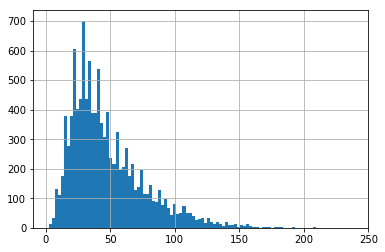

In [12]:
## (2) SERENDIPTY DATASET: SER

## (6) serendipity-sac2018
# https://grouplens.org/datasets/serendipity-2018/

dataset = "serendipity-sac2018"

# userId,movieId (3840, 2)
SER_recommendations = pd.read_csv(Dataset_directory+ dataset +os.sep+"recommendations.csv")

# userId,movieId,rating,timestamp,predictedRating,s1,s2,s3,s4,s5,s6,s7,s8,q,
# s_ser_rel,s_ser_find,s_ser_imp,s_ser_rec,m_ser_rel,m_ser_find,m_ser_imp,m_ser_rec (3840, 2)
# survey likert questions about 'serendipitous' (generally unpopular but they like) movies
# and then some inferred binary variables based on those answers
SER_answers = pd.read_csv(Dataset_directory+ dataset +os.sep+"answers.csv")

# ORIGINAL CSV HAS PROBLEMS (don't story comma separated list within "" ... and then *also* use "" for Jed "nickname" Jones)
# it's only 5-6 entries - MANUAL FIX is fine
# movieId,title,releaseDate,directedBy,starring,imdbId,tmdbId,genres (49174, 8)
# -> movieId,title,releaseDate,imdbId,tmdbId (good for identifying)
# genres -> comma separated string list
# starring -> comma separated string list
# directedBy -> comma separated string list
SER_movies = pd.read_csv(Dataset_directory+ dataset +os.sep+"movies.csv") # movieId is unique

# userId,movieId,tag,timestamp (628157, 4)
SER_tags = pd.read_csv(Dataset_directory+ dataset +os.sep+"tags.csv")

# userId,movieId,rating,timestamp (9997850, 4)
SER_training = pd.read_csv(Dataset_directory+ dataset +os.sep+"training.csv")

# movieId,tag,relevance (12413640, 3)
SER_tag_genome = pd.read_csv(Dataset_directory+ dataset +os.sep+"tag_genome.csv")

# pick the most relevant tags/tags above certain relevance
SER_tag_genome[ SER_tag_genome["relevance"]>.5 ].groupby('movieId').count()["tag"].hist(bins=100)

SER_answers_by_movieId = SER_answers.groupby("movieId").mean().drop(["userId","timestamp"],axis=1)
SER_answers_by_movieId["n"] = SER_answers.groupby('movieId').count()["userId"]

SER_movie_ratings = SER_training[["movieId","rating"]].groupby("movieId").apply(lambda x: [x["rating"].count(), x["rating"].mean(), x["rating"].std()])
SER_movie_ratings = SER_movie_ratings.apply(pd.Series)
SER_movie_ratings.columns = ["ratings_n","ratings_mean","ratings_std"]
SER_movie_ratings["ratings_n"] = SER_movie_ratings["ratings_n"].astype('int')


In [13]:
num_directors = SER_movies["directedBy"].apply(lambda x: len(x.split(",")) if pd.notnull(x) else np.nan)
director_list = SER_movies["directedBy"].apply(lambda x: x.split(",") if pd.notnull(x) else np.nan)
# (0)1-30 directors, mode=1

SER_movies["director_list"] = director_list
SER_movies["num_directors"] = num_directors

num_genres = SER_movies["genres"].apply(lambda x: len(x.split(",")) if pd.notnull(x) else np.nan)
genres_list = SER_movies["genres"].apply(lambda x: x.split(",") if pd.notnull(x) else np.nan)
# (0)1-10 genres, mode =1

SER_movies["genres_list"] = genres_list
SER_movies["num_genres"] = num_genres

num_starring = SER_movies["starring"].apply(lambda x: len(x.split(",")) if pd.notnull(x) else np.nan)
starring_list = SER_movies["starring"].apply(lambda x: x.split(",") if pd.notnull(x) else np.nan)
# (0)1-70 starring, mode=5

SER_movies["starring_list"] = starring_list
SER_movies["num_starring"] = num_starring

# titles are form title (year) and not unique

# releaseDates = pd.to_datetime(SER_movies["releaseDate"]).apply(lambda x: x.date())
# throws error - we'll have to decide where we do all the date/release year processing

In [14]:
# OUTPUT: SER_movies

SER_movies.index = SER_movies["movieId"]
SER_movies[SER_movie_ratings.columns] = SER_movie_ratings
SER_movies[SER_answers_by_movieId.columns] = SER_answers_by_movieId


# tags/tag genome/recommendations - we don't use yet
# we only take the 'answers' df because it's really easily to output a per movie average
# not finished - some cleaning/prep still required

SER_movies.drop(["directedBy","starring","genres"],axis=1,inplace=True)
SER_movies.to_csv(Dataset_directory+"Processed"+os.sep+"SER_movies"+".csv")

# SER_answers_by_movieId.to_csv(Dataset_directory+"Processed"+os.sep+"SER_answers_by_movieId"+".csv")
# SER_movie_ratings.to_csv(Dataset_directory+"Processed"+os.sep+"SER_movie_ratings"+".csv")

In [15]:
SER_movies

,movieId,title,releaseDate,imdbId,tmdbId,director_list,num_directors,genres_list,num_genres,starring_list,...,q,s_ser_rel,s_ser_find,s_ser_imp,s_ser_rec,m_ser_rel,m_ser_find,m_ser_imp,m_ser_rec,n
movieId,,,,,,,,,,,,,,,,,,,,,
1,1,Toy Story (1995),1995-11-19,114709,862.0,[John Lasseter],1.0,"[Adventure, Animation, Children, Comedy, Fantasy]",5.0,"[Tim Allen, Tom Hanks, Don Rickles, Jim Var...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Jumanji (1995),1995-12-15,113497,8844.0,[Joe Johnston],1.0,"[Adventure, Children, Fantasy]",3.0,"[Jonathan Hyde, Bradley Pierce, Robin Willia...",...,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,Grumpier Old Men (1995),1995-01-01,113228,15602.0,[Howard Deutch],1.0,"[Comedy, Romance]",2.0,"[Jack Lemmon, Walter Matthau, Ann-Margret , ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Waiting to Exhale (1995),1996-01-15,114885,31357.0,[Forest Whitaker],1.0,"[Comedy, Drama, Romance]",3.0,"[Angela Bassett, Loretta Devine, Whitney Hou...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,Father of the Bride Part II (1995),1995-12-08,113041,11862.0,[Charles Shyer],1.0,[Comedy],1.0,"[Steve Martin, Martin Short, Diane Keaton, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,Heat (1995),1995-01-01,113277,949.0,[Michael Mann],1.0,"[Action, Crime, Thriller]",3.0,"[Robert De Niro, Al Pacino, Val Kilmer, Jon...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,Sabrina (1995),1995-01-01,114319,11860.0,[Sydney Pollack],1.0,"[Comedy, Romance]",2.0,"[Harrison Ford, Greg Kinnear, Nancy Marchand...",...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,8,Tom and Huck (1995),1995-12-22,112302,45325.0,[Peter Hewitt],1.0,"[Adventure, Children]",2.0,"[Jonathan Taylor Thomas, Brad Renfro, Eric S...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,Sudden Death (1995),1995-12-22,114576,9091.0,[Peter Hyams],1.0,[Action],1.0,"[Raymond J. Barry, Powers Boothe, Jean-Claud...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
####################################################################################################################
#------------------------------------------------------------------------------------------------------------------#
####################################################################################################################

In [17]:
## (3) LEARNING DATASET: LEARN

# https://grouplens.org/datasets/learning-from-sets-of-items-2019/
# For this paper: https://www.thinkmind.org/download.php?articleid=eknow_2017_4_10_68011

dataset = "learning-from-sets-2019"

# userId,movieId_1,movieId_2,movieId_3,movieId_4,movieId_5,rating,timestamp (29516, 8)
LEARN_set_ratings = pd.read_csv(Dataset_directory+ dataset +os.sep+"set_ratings.csv")

# userId,movieId,rating,timestamp (458970, 4)
LEARN_item_ratings = pd.read_csv(Dataset_directory+ dataset +os.sep+"item_ratings.csv")


LEARN_movie_ratings = LEARN_item_ratings[["movieId","rating"]].groupby("movieId").apply(lambda x: [x["rating"].count(), x["rating"].mean(), x["rating"].std()])
LEARN_movie_ratings = LEARN_movie_ratings.apply(pd.Series)
LEARN_movie_ratings.columns = ["n","ratings_mean","ratings_std"]


In [18]:
# OUTPUT: LEARN_movie_ratings

# we're not doing anything with the (ratings of sets of movies) set data here, just the accompanying item (one movie-at-a-time data)

LEARN_movie_ratings["n"] = LEARN_movie_ratings["n"].astype('int')
LEARN_movie_ratings.to_csv(Dataset_directory+"Processed"+os.sep+"LEARN_movie_ratings"+".csv")

In [19]:
####################################################################################################################
#------------------------------------------------------------------------------------------------------------------#
####################################################################################################################

In [20]:
## (4) HETREC DATASET: HETREC
# http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt
# MovieLens + IMDb/Rotten Tomatoes

# Some restrictions on commercial use -> Have sent them a begging letter!

dataset = "hetrec2011-movielens-2k-v2"

# This file contains the main actores and actresses of the movies.
# A ranking is given to the actors of each movie according to the order in which 
# they appear on the movie IMDb cast web page. (same as "order" in tmdb)
# movieID,actorID,actorName,ranking (231742, 4)
# movieID *not* unique
HETREC_movie_actors = pd.read_csv(Dataset_directory+ dataset +os.sep+"movie_actors.dat", sep=r'\t', engine='python')

# movieID,country (10197, 2)
# movieID unique, country only 71 different options, but don't look like iso standard! ("palestinian occupied territories")
HETREC_movie_countries = pd.read_csv(Dataset_directory+ dataset +os.sep+"movie_countries.dat", sep=r'\t', engine='python')

# movieID,directorID,directorName (10155, 3)
# movieID unique, directorName mostly refers to a *single director*
# Some weird values = Director Ridley Scott, Daniel Davis [Edward D. Wood Jr.], Grigori Chukhraj & Valentin Yezhov
HETREC_movie_directors = pd.read_csv(Dataset_directory+ dataset +os.sep+"movie_directors.dat", sep=r'\t', engine='python')

# movieID,genre (20809, 2)
# movieID *not* unique, 20 different genres (some pretty empty short=1, IMAX=25)
HETREC_movie_genres = pd.read_csv(Dataset_directory+ dataset +os.sep+"movie_genres.dat", sep=r'\t', engine='python')

# movieID,location1,location2,location3,location4 (49167, 5)
# movieID *not* unique, location1-4 operate like address ... a lot of the time location1 is a country
# but sometimes it's a ship! or "Israeli-Jordanian Border"
# Lot of work to get anything more consistent than "number of locations"
HETREC_movie_locations = pd.read_csv(Dataset_directory+ dataset +os.sep+"movie_locations.dat", sep=r'\t', engine='python')

# movieID,tagID,tagWeight (51795, 3)
# powerlaw distribution with tagWeight -could use to really thin down
# movieID *not* unique
HETREC_movie_tags = pd.read_csv(Dataset_directory+ dataset +os.sep+"movie_tags.dat", sep=r'\t', engine='python')

# id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,
# rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,
# rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,
# rtAudienceScore,rtPictureURL (10197, 21)
HETREC_movies = pd.read_csv(Dataset_directory+ dataset +os.sep+"movies.dat", sep=r'\t', engine='python')

# id,value (13222, 2)
# id -> content for all tags (1 = "earth")
HETREC_tags = pd.read_csv(Dataset_directory+ dataset +os.sep+"tags.dat", sep=r'\t', engine='python')

# userID,movieID,rating,date_day,date_month,date_year,date_hour,date_minute,date_second (855598, 9)
# full time stamp for each individual rating, broken down into separate columns
HETREC_user_ratedmovies = pd.read_csv(Dataset_directory+ dataset +os.sep+"user_ratedmovies.dat", sep=r'\t', engine='python')

# userID,movieID,rating,timestamp (855598, 4)
# same but with timestamp object
HETREC_user_ratedmovies_timestamps = pd.read_csv(Dataset_directory+ dataset +os.sep+"user_ratedmovies-timestamps.dat", sep=r'\t', engine='python')

# userID,movieID,tagID,date_day,date_month,date_year,date_hour,date_minute,date_second (47957, 9)
# full time stamp for each individual tagging, broken down into separate columns
HETREC_user_taggedmovies = pd.read_csv(Dataset_directory+ dataset +os.sep+"user_taggedmovies.dat", sep=r'\t', engine='python')

# userID,movieID,tagID,timestamp (47957, 4)
# same but with timestamp object
HETREC_user_taggedmovies_timestamps = pd.read_csv(Dataset_directory+ dataset +os.sep+"user_taggedmovies-timestamps.dat", sep=r'\t', engine='python')



In [21]:
# HETREC_user_ratedmovies_timestamps.groupby("movieId")
HETREC_user_ratedmovies_timestamps = HETREC_user_ratedmovies_timestamps.rename(columns = {'movieID':'movieId'})
HETREC_movie_ratings = HETREC_user_ratedmovies_timestamps[["movieId","rating"]].groupby("movieId").apply(lambda x: [x["rating"].count(), x["rating"].mean(), x["rating"].std()])
# ML_movie_ratings = ML_ratings[["movieId","rating"]].groupby("movieId").apply(lambda x: [x["rating"].count(), x["rating"].mean(), x["rating"].std()])
HETREC_movie_ratings = HETREC_movie_ratings.apply(pd.Series)
HETREC_movie_ratings.columns = ["ratings_n","ratings_mean","ratings_std"]
HETREC_movie_ratings['ratings_n'] = HETREC_movie_ratings['ratings_n'].astype('int')

In [22]:
# harmonise imdbId column to match all others
HETREC_movies = HETREC_movies.rename(columns = {'imdbID':'imdbId'})

# harmonise id columns to movieID and set index equal to that
HETREC_movies = HETREC_movies.rename(columns = {'id':'movieId'})
HETREC_movies.index = HETREC_movies["movieId"]

# add country data to HETREC_movies
HETREC_movie_countries = HETREC_movie_countries.rename(columns = {'movieID':'movieId'})
HETREC_movie_countries.index = HETREC_movie_countries["movieId"]
HETREC_movies["country"] = HETREC_movie_countries["country"]

# add director data to HETREC_movies
HETREC_movie_directors = HETREC_movie_directors.rename(columns = {'movieID':'movieId'})
HETREC_movie_directors.index = HETREC_movie_directors["movieId"]
HETREC_movies[["directorID","directorName"]] = HETREC_movie_directors[["directorID","directorName"]]

# add movie_ratings to HETREC_movies
HETREC_movies[HETREC_movie_ratings.columns] = HETREC_movie_ratings

# imdbPictureURL 181 nulls
# rtID 311 nulls
# id unique
# imdbID -> not unique
# rtID -> not unique

In [23]:
numerical_cols = ['rtAllCriticsRating', 'rtAllCriticsNumReviews',
       'rtAllCriticsNumFresh', 'rtAllCriticsNumRotten', 'rtAllCriticsScore',
       'rtTopCriticsRating', 'rtTopCriticsNumReviews', 'rtTopCriticsNumFresh',
       'rtTopCriticsNumRotten', 'rtTopCriticsScore', 'rtAudienceRating',
       'rtAudienceNumRatings', 'rtAudienceScore']
HETREC_movies[numerical_cols] = HETREC_movies[numerical_cols].replace("\\N",np.nan).apply(lambda x: pd.to_numeric(x))

# "\\N" appears to be the code for nan (maybe in same 230??)

# imdbPictureURL -> full url for jpg, not unique
# rtPictureURL -> \\N for 230, post_default for 57, otherwise similar non-unique pattern

# rtId -> string id, similar-but-not-identical pattern of not-uniqueness
# rtAllCriticsRating -> 0 is very common, \\N also present (0.0-9.5999)
# rtAllCriticsNumReviews -> integers
# rtAllCriticsNumFresh -> integers how many gave a "fresh" rating
# rtAllCriticsNumRotten -> integers how many gave a "rotten" rating (skewed v against!)
# rtTopCriticsScore -> integer score 0-100 (lot of 0s!)
# rtAudienceRating -> float 0.0-5.0 (lot of 0s!)
# rtAudienceNumRatings-> integers lotof 0s!
# rtAudienceScore -> integeers 0-100, lot of 0s!
# HETREC_movies["rtAudienceNumRatings"].value_counts()
# HETREC_movies["rtAudienceRating"].replace("\\N",np.nan).astype('float').max()


In [24]:
# rotten tomatoes data, adding some extra variables and setting missing values appropriately

rtAllCriticsNoReviews = HETREC_movies["rtAllCriticsNumReviews"]==0.0
HETREC_movies["rtAllCriticsFracRotten"] = HETREC_movies["rtAllCriticsNumRotten"]/HETREC_movies["rtAllCriticsNumReviews"]
HETREC_movies.loc[rtAllCriticsNoReviews,"rtAllCriticsRating"] = np.nan
HETREC_movies.loc[rtAllCriticsNoReviews,"rtAllCriticsScore"] = np.nan
HETREC_movies.loc[rtAllCriticsNoReviews,"rtAllCriticsFracRotten"] = np.nan

rtTopCriticsNoReviews = HETREC_movies["rtTopCriticsNumReviews"]==0.0
HETREC_movies["rtTopCriticsFracRotten"] = HETREC_movies["rtTopCriticsNumRotten"]/HETREC_movies["rtTopCriticsNumReviews"]
HETREC_movies.loc[rtTopCriticsNoReviews,"rtTopCriticsRating"] = np.nan
HETREC_movies.loc[rtTopCriticsNoReviews,"rtTopCriticsScore"] = np.nan
HETREC_movies.loc[rtTopCriticsNoReviews,"rtTopCriticsFracRotten"] = np.nan

rtAudienceNoRatings = HETREC_movies["rtAudienceNumRatings"]==0.0
# HETREC_movies["rtTopCriticsFracRotten"] = HETREC_movies["rtTopCriticsNumRotten"]/HETREC_movies["rtTopCriticsNumReviews"]
HETREC_movies.loc[rtAudienceNoRatings,"rtAudienceRating"] = np.nan
HETREC_movies.loc[rtAudienceNoRatings,"rtAudienceScore"] = np.nan
# HETREC_movies["rtTopCriticsFracRotten"][rtAudienceNoRatings] = np.nan

HETREC_movies.loc[ HETREC_movies["rtAllCriticsRating"]==0.0 , "rtAllCriticsRating"] = np.nan
HETREC_movies.loc[ HETREC_movies["rtTopCriticsRating"]==0.0 , "rtTopCriticsRating"] = np.nan

In [25]:
# add genre data to HETREC_movies
genres = pd.DataFrame(HETREC_movie_genres['genre'].unique())

for gen_ind in genres.index:
    gen_name = "genres__"+genres.loc[gen_ind,0]    
    genre_indices = HETREC_movie_genres[ HETREC_movie_genres["genre"]==genres.loc[gen_ind,0] ]["movieID"]
    HETREC_movies[gen_name] = np.nan
    
    HETREC_movies.loc[HETREC_movie_genres["movieID"].unique(),gen_name] = 0
    HETREC_movies.loc[genre_indices,gen_name] = 1
    

In [26]:
# OUTPUT: HETREC_movies, HETREC_movie_actors
# output per movie dataset
HETREC_movies.to_csv(Dataset_directory+"Processed"+os.sep+"HETREC_movies"+".csv")

# we're not using HETREC_movie_locations because it looks like junk/a nightmare to extract something useful from

# HETREC_tags/HETREC_user_taggedmovies/HETREC_user_taggedmovies_timestamps can wait until we try do something with tags

# this will be work to integrate - we'll have to check whether it's worth it (overlap with tmbd_cast?)
HETREC_movie_actors["order"] = HETREC_movie_actors["ranking"]-1
# ranking same as tmdb "order" but starts at 1 not 0
HETREC_movie_actors.drop("ranking",axis=1,inplace=True)
HETREC_movie_actors.to_csv(Dataset_directory+"Processed"+os.sep+"HETREC_cast"+".csv")



In [27]:
####################################################################################################################
#------------------------------------------------------------------------------------------------------------------#
####################################################################################################################

In [64]:
## (5) ML LATEST DATASET: ML
## The Movie Lens latest 58k movies

dataset = "Movie_Lens_Latest"
# informative README.txt!

# tagId,tag (1128,  2)
# id -> id content
ML_genome_tags = pd.read_csv(Dataset_directory+ dataset +os.sep+"genome-tags.csv")

# movieId,imdbId,tmdbId (58,098,  3)
ML_links = pd.read_csv(Dataset_directory+ dataset +os.sep+"links.csv")

# movieId,title,genres (58,098,  3)
# genres -> | separated list
#    Romance,Fantasy,IMAX,Action,Sci-Fi,Western,Drama,Horror,Mystery,Adventure,War,Comedy,Musical,Documentary,Thriller,
#    Film-Noir,(no genres listed),Crime,Animation,Children'
ML_movies = pd.read_csv(Dataset_directory+ dataset +os.sep+"movies.csv")

# userId,movieId,tag,timestamp (1,108,997,  4)
# tags look user submitted - 74714 different tags - not consistent with genome_tags length/tagId range
ML_tags = pd.read_csv(Dataset_directory+ dataset +os.sep+"tags.csv")

# movieId,tagId,relevance (14,862,528,  3)
# each of 1128 tagIds x 13176 movieIds (dense matrix)
# relevance is machine learning output (inverse distribution)
ML_genome_scores = pd.read_csv(Dataset_directory+ dataset +os.sep+"genome-scores.csv")

# userId,movieId,rating,timestamp (27,753,444,  4)
ML_ratings = pd.read_csv(Dataset_directory+ dataset +os.sep+"ratings.csv")


In [65]:
ML_movie_ratings = ML_ratings[["movieId","rating"]].groupby("movieId").apply(lambda x: [x["rating"].count(), x["rating"].mean(), x["rating"].std()])
ML_movie_ratings = ML_movie_ratings.apply(pd.Series)
ML_movie_ratings.columns = ["ratings_n","ratings_mean","ratings_std"]
ML_movie_ratings['ratings_n'] = ML_movie_ratings['ratings_n'].astype('int')

In [66]:
ML_movies["genres_list"] = ML_movies["genres"].apply(lambda x: x.split("|") if pd.notnull(x) else np.nan)

flat_list = [item for sublist in ML_movies["genres_list"].dropna().values for item in sublist]
genres = pd.DataFrame(flat_list).drop_duplicates()#.sort_values(by="movieId")
drop_ind = genres[genres[0]=="(no genres listed)"].index[0]
genres.drop(drop_ind , inplace=True)
for gen_ind in genres.index: # ditch "no genre" index!
    gen_name = "genres__"+genres.loc[gen_ind,0] 
    ML_movies[gen_name] = ML_movies["genres_list"].apply(lambda x: genres.loc[gen_ind,0] in x if isinstance(x,list) or pd.notnull(x) else np.nan).astype('float')
    
# ML_genre_vars = search(ML_movies,"ML_genres__[A-Z]",case_sensitive=True)
# ML_genre_vars

In [67]:
# OUTPUT: ML_movies, ML_links


# deal with tags/relevance scores later

ML_movies.index = ML_movies["movieId"]
ML_movies[ML_movie_ratings.columns] = ML_movie_ratings
ML_movies.drop(["genres","genres_list"],axis=1,inplace=True)
ML_movies.to_csv(Dataset_directory+"Processed"+os.sep+"ML_movies.csv")

# ML_movie_ratings.to_csv(Dataset_directory+"Processed"+os.sep+"ML_movie_ratings.csv") 
ML_links.index = ML_links["movieId"]
ML_links.to_csv(Dataset_directory+"Processed"+os.sep+"ML_links.csv")
# could split up genres


In [32]:
####################################################################################################################
#------------------------------------------------------------------------------------------------------------------#
####################################################################################################################

In [33]:
## (6) the-numbers.com DATASET: NUM

# superficial, polite, respectful scrape of freely available financial data from the-numbers.com
# 5769 films
# title|link|production_budget|domestic_gross|worldwide_gross|release_year|release_month|release_day|movieId|worldwide_gross_divided_by_budget|international_gross|domestic_gross_fraction

In [34]:
# OUTPUT: NUM_movies

NUM_movies = pd.read_csv(Dataset_directory+"Processed"+os.sep+"NUM_movies"+".csv", index_col = "scrape_count.1")
NUM_movies.index.name = "scrape_count"
NUM_movies.drop( ["scrape_count","date","page_no"], axis=1, inplace=True )

NUM_movies[ ['production_budget', 'domestic_gross', 'worldwide_gross'] ].replace(0, np.nan, inplace=True)

NUM_movies["worldwide_gross_divided_by_budget"] = NUM_movies["worldwide_gross"] / NUM_movies["production_budget"]
NUM_movies["international_gross"] = (NUM_movies["worldwide_gross"] - NUM_movies["domestic_gross"])
NUM_movies["domestic_gross_fraction"] = (NUM_movies["domestic_gross"] / NUM_movies["worldwide_gross"])

NUM_movies.to_msgpack(Dataset_directory+"Processed"+os.sep+"NUM_movies"+".msgpack")

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\pandas\core\frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [35]:
####################################################################################################################
#------------------------------------------------------------------------------------------------------------------#
####################################################################################################################

In [36]:
## (7) themoviedatabase.com API DATASET: TMB

tmdb_dir = create_subdir(Dataset_directory, "themoviedb")


company = pd.read_msgpack(tmdb_dir + "company_cleaned.msgpack")
collections = pd.read_msgpack(tmdb_dir + "collections_cleaned.msgpack")
person_ids = pd.read_msgpack(tmdb_dir + "person_ids_cleaned.msgpack")
person_ids.index = person_ids.id

keywords_categories = pd.read_msgpack(tmdb_dir + "keywords_cleaned.msgpack")
keywords_categories.index = keywords_categories.id
genre_categories = pd.read_msgpack( tmdb_dir + "genres.msgpack")
genre_categories.index = genre_categories.id
production_country_categories = pd.read_msgpack( tmdb_dir + "production_countries.msgpack")
language_categories = pd.read_msgpack( tmdb_dir + "languages.msgpack") ## list of tmdb spoken languages


In [37]:
# 'adult|alternative_titles|backdrop_path|belongs_to_collection|budget|genres|homepage|tmbdId|imdbId|keywords|
# original_language|original_title|overview|popularity|poster_path|production_companies|production_countries|
# release_date|revenue|runtime|spoken_languages|status|tagline|title|video|vote_average|vote_count|
# facebook_id|instagram_id|twitter_id|num_genres|num_production_companies|num_production_countries|num_spoken_languages|
# num_alternative_titles|num_keywords|cast_size|crew_size|cast_credit_list|crew_credit_list'
movies = pd.read_msgpack(tmdb_dir + "movies_full_final.msgpack")
movies.rename(columns = {'id':'tmdbId'},inplace=True)
movies.rename(columns = {'imdb_id':'imdbId'},inplace=True)
movies.index.name = 'tmdbId'

# 'cast_id|character|credit_id|gender|id|order|tmdb_id|max_order|fractional_order'
TMB_cast = pd.read_msgpack( tmdb_dir+"TMB_cast"+".msgpack")
# 'credit_id|department|gender|id|job|tmdb_id|order|max_order|fractional_order'
TMB_crew = pd.read_msgpack( tmdb_dir+"TMB_crew"+".msgpack")


# 'gender|id|name|profile_path|credit_list|credit_number|mean_order|fractional_mean_order|order_list|gender_guesser|
# importulence|profile_path_cast|gender_guess_integrated|cast_crew_overlap|adult|known_for_department|popularity|
# death_day|death_month|death_year|birth_day|birth_month|birth_year'
TMB_cast_individuals = pd.read_msgpack( tmdb_dir+"TMB_cast_individuals"+".msgpack")

# 'gender|id|name|profile_path|credit_list|credit_number|mean_order|fractional_mean_order|
# order_list|department_list|department_number|job_list|job_number|gender_guesser|importulence|
# gender_guess_integrated|cast_crew_overlap|adult|known_for_department|popularity|
# death_day|death_month|death_year|birth_day|birth_month|birth_year'
TMB_crew_individuals = pd.read_msgpack( tmdb_dir+"TMB_crew_individuals"+".msgpack")

# index tmdb
# 'gender_guess_integrated_crew_mean|gender_guess_integrated_cast_mean|gender_guess_integrated_crew_lead|
# gender_guess_integrated_cast_lead|gender_guess_integrated_crew_lead5|gender_guess_integrated_cast_lead5|
# credit_number_crew_mean|credit_number_cast_mean|credit_number_crew_lead|credit_number_cast_lead|credit_number_crew_lead5|
# credit_number_cast_lead5|job_number_crew_mean|job_number_crew_lead|job_number_crew_lead5|department_number_crew_mean|
# department_number_crew_lead|department_number_crew_lead5|mean_order_crew_mean|mean_order_cast_mean|mean_order_crew_lead|
# mean_order_cast_lead|mean_order_crew_lead5|mean_order_cast_lead5|fractional_mean_order_crew_mean|
# fractional_mean_order_cast_mean|fractional_mean_order_crew_lead|fractional_mean_order_cast_lead|
# fractional_mean_order_crew_lead5|fractional_mean_order_cast_lead5|importulence_crew_mean|importulence_cast_mean|
# importulence_crew_lead|importulence_cast_lead|importulence_crew_lead5|importulence_cast_lead5'
TMB_cast_crew_aggregates = pd.read_msgpack(tmdb_dir+"TMB_cast_crew_aggregates"+".msgpack")
TMB_cast_crew_aggregates.index.name = "tmdbId"


# very chunky!
# release_dates = pd.read_msgpack(tmdb_dir + "release_dates.msgpack")


In [38]:
movies[TMB_cast_crew_aggregates.columns]= TMB_cast_crew_aggregates

In [39]:
####################################################################################################################
#------------------------------------------------------------------------------------------------------------------#
####################################################################################################################

In [40]:
## (8) themoviedatabase.com Kaggle DATASET: TMDB_KAGGLE
dataset = "The_Movies_Dataset"

# userId,movieId,rating,timestamp (26024289, 4)
TMDB_KAGGLE_ratings = pd.read_csv(Dataset_directory+ dataset +os.sep+"ratings.csv")

# movieId, imdbId, tmdbId (45843, 3)
TMDB_KAGGLE_links_large = pd.read_csv(Dataset_directory+ dataset +os.sep+"links.csv")

# movieId, imdbId, tmdbId (9125, 3)
TMDB_KAGGLE_links_small = pd.read_csv(Dataset_directory+ dataset +os.sep+"links_small.csv")

# movieId, imdbId, tmdbId (45853, 3) + 10 (prob causing overlaps!)
TMDB_KAGGLE_links = TMDB_KAGGLE_links_large.append(TMDB_KAGGLE_links_small).drop_duplicates()

TMDB_KAGGLE_links.drop([5173,7527],inplace=True)
TMDB_KAGGLE_links["imdbId"] = TMDB_KAGGLE_links["imdbId"].astype('int')

# TMB_links_amalgamated.isnull().sum()

drop_indices = [13446, 16880, 5574, 9378, 29684, 20100, 14023, 16278, 848, 20065, 12131, 45641, 13676, 34144, 2594, 11217, 45197, 33499, 21093, 14089, 9215, 15871, 4390, 1485, 15165, 17350, 14077, 9631, 34061, 13289]
TMDB_KAGGLE_links.loc[drop_indices,"tmdbId"] = np.nan

In [41]:
del TMDB_KAGGLE_ratings,TMB_cast_crew_aggregates,TMB_crew_individuals,TMB_cast_individuals,TMB_crew,TMB_cast
del ML_movie_ratings,ML_genome_tags,ML_tags,ML_genome_scores
del HETREC_movie_actors,HETREC_movie_directors,HETREC_movie_ratings
del HETREC_user_taggedmovies_timestamps,HETREC_user_taggedmovies,HETREC_user_ratedmovies_timestamps
del HETREC_user_ratedmovies,HETREC_tags,HETREC_movie_locations,HETREC_movie_tags
del SER_movie_ratings,SER_answers_by_movieId,PERS_movie_ratings,PERS_ratings
del SER_tag_genome, ML_ratings, SER_training, person_ids, LEARN_item_ratings, SER_tags

In [43]:
gc.collect()

182

In [44]:
####################################################

In [45]:
## linking the whole dataset

# SER_links -> movieId,imdbId,tmdbId (49174,  3)
SER_links = SER_movies[["movieId","imdbId","tmdbId"]].copy()
# HETREC_links -> movieId,imdbId (10197,  2)
HETREC_links = HETREC_movies[["movieId","imdbId"]].copy() # could add rtID on if you like
# TMB_links -> tmdbId,imdbId (467917,  2)
TMB_links = movies[["tmdbId","imdbId"]].copy()

# ML_links -> movieId,imdbId,tmdbId (58098,  3)
# TMDB_KAGGLE_links -> movieId,imdbId,tmdbId (45853,  3)

# NUM -> pre-existing links to movieId
# PERS -> movieId
# LEARN -> movieId

In [46]:
all_links = TMDB_KAGGLE_links.copy()
all_links = all_links.append(ML_links,ignore_index=True,sort=False)
all_links = all_links.append(TMB_links,ignore_index=True,sort=False)
all_links = all_links.append(SER_links,ignore_index=True,sort=False)
all_links = all_links.append(HETREC_links,ignore_index=True,sort=False)
all_links = all_links.drop_duplicates()
# movieId now unique (when you drop tmdbId nulls)

In [47]:
movieId_by_tmdbId = all_links[["movieId","tmdbId"]].dropna().drop_duplicates()
movieId_by_tmdbId.index = movieId_by_tmdbId["movieId"]
null_tmbdIds = all_links["tmdbId"].isnull()
all_links.loc[null_tmbdIds, "tmdbId"] = all_links[ null_tmbdIds ].apply(lambda x: movieId_by_tmdbId.loc[x["movieId"],"tmdbId"] if x["movieId"] in movieId_by_tmdbId.index else np.nan, axis=1)

In [48]:
all_links.isnull().sum()

movieId    467917
imdbId     132736
tmdbId        977
dtype: int64

In [49]:
all_links.dtypes

movieId    float64
imdbId     float64
tmdbId     float64
dtype: object

In [50]:
# movies.drop("movieId",axis=1, inplace=True)
movies["tmdbId"].isnull().sum()

0

In [53]:
#

In [54]:
# TMDB_KAGGLE_links["movieId"].loc[movies["tmdbId"][0:100]]
temp = TMDB_KAGGLE_links[["movieId","tmdbId"]].dropna().drop_duplicates(subset = ["tmdbId"])
temp.index = temp["tmdbId"]

movies["movieId"] = movies["tmdbId"].apply(lambda x:temp["movieId"].loc[x] if x in temp.index else np.nan )


In [55]:
# get a set of link unique in tmdbId
tmdbId_links = all_links[all_links["tmdbId"].notnull()].copy()
tmdbId_links.index = range(0,tmdbId_links.shape[0])
tmdbId_links.sort_values(by="movieId", inplace=True)
tmdbId_links.drop_duplicates(subset = ["tmdbId"],inplace=True)
tmdbId_links.index = tmdbId_links["tmdbId"]

movies.loc[movies["movieId"].isnull(),"movieId"] = movies.loc[movies["movieId"].isnull(),"tmdbId"].apply(lambda x:tmdbId_links["movieId"].loc[x] if x in tmdbId_links.index else np.nan )

In [56]:
# del tmdbId_links

In [57]:
movies["movieId"].isnull().sum()

410590

In [ ]:
# movies["movieId"] = movies["movieId"].astype('float32')

517

In [68]:
INT_df = movies.copy()
INT_df.columns = ["TMB_"+x for x in INT_df.columns]

temp = HETREC_movies.copy()
temp.columns = ["HETREC_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', left_on ='TMB_movieId', right_on = 'movieId')

temp = SER_movies.copy()
temp.columns = ["SER_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', left_on ='TMB_movieId', right_on = 'movieId')

temp = PERS_ratings_and_big5.copy()
temp.columns = ["PERS_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', left_on ='TMB_movieId', right_on = 'movieId')

temp = ML_movies.copy()
temp.columns = ["ML_"+x for x in temp.columns]
temp.index.name = "movieId"
INT_df = INT_df.merge(temp, how ='outer', left_on ='TMB_movieId', right_on = 'movieId')

temp = NUM_movies[NUM_movies["movieId"].notnull()].copy()
temp.index = temp["movieId"]
temp.columns = ["NUM_"+x for x in temp.columns]
INT_df = INT_df.merge(temp, how ='outer', left_on ='TMB_movieId', right_on = 'movieId')




# INT_df.to_csv(Dataset_directory+"Processed"+os.sep+"INT_df"+".csv")

In [ ]:
# pd.DataFrame.from_dict( json.loads(res) )
# ~7 hrs -> 86,000 rows out of 450,000
# 36.4 -> another 30hrs
# 1/5 -> 300MB -> 1.5Gb (maybe save to other hd!)
# ram not an issue - 200MB for tmbd_df


def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)


def memory_use(locs = locals().items()):
    gc.collect()
    # locals().items()
    for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locs),
                             key= lambda x: -x[1])[:10]:
        print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

In [ ]:
# import sys
# memory_use(locs = locals().items())

In [ ]:
# INT_df.columns[INT_df.dtypes=='object']

In [71]:
secondary_tmdb_dir = "E:\\Datasets\\themoviedb"
INT_df.to_msgpack(secondary_tmdb_dir+os.sep+"INT_df.msgpack")

In [ ]:
# INT_df["TMB_tmdbId"].value_counts()
# TMB_video
# HETREC_country -> category?
# TMB_genres